# Predict The Earth Quake Damages Level In Nepal

We're trying to predict the ordinal variable damage_grade, which represents a level of damage to the building that was hit by the earthquake. There are 3 grades of the damage:

- 1 represents low damage
- 2 represents a medium amount of damage
- 3 represents almost complete destruction

In [134]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from category_encoders import OrdinalEncoder, OneHotEncoder

import lightgbm as lgb


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.dummy import DummyClassifier

import optuna
from sklearn.model_selection import cross_val_score

print(f"Done in {np.count_nonzero([1,2,3, 4, 5, 6, 7, 8, 9, 10])} seconds")

Done in 10 seconds


### Load data

In [2]:
# load data
train_values = pd.read_csv('./data/train_values.csv')
train_labels = pd.read_csv('./data/train_labels.csv')
test_values = pd.read_csv('./data/test_values.csv')

In [3]:
print(train_values.shape)
train_values.head()

(260601, 39)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [6]:
print(train_labels.shape)
train_labels.head()

(260601, 2)


,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [7]:
print(test_values.shape)
test_values.head()

(86868, 39)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


### Data Preparation

In [3]:
train_values = train_values.merge(train_labels, on='building_id')
train_values.shape

(260601, 40)

In [9]:
train_values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


In [10]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [12]:
# Check if there is any missing values in the dataset
train_values.isnull().any().any()

np.False_

### Data Exploration & Processing

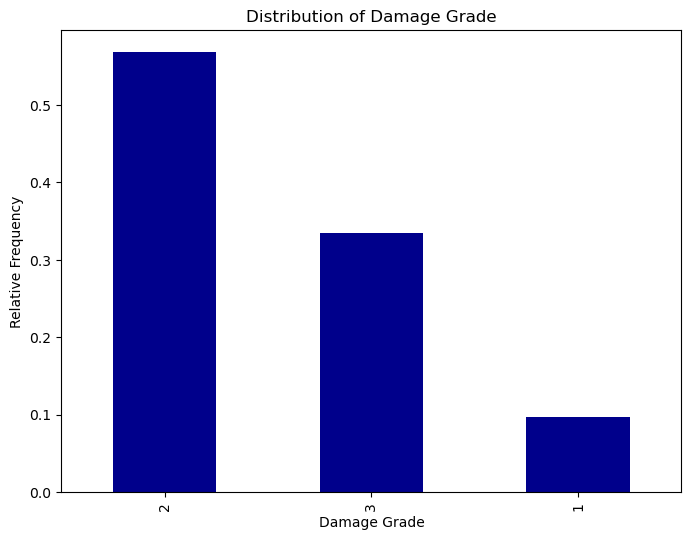

In [5]:
#  plot the damage class
plt.figure(figsize=(8, 6))
train_values["damage_grade"].value_counts(normalize=True).plot(kind='bar', color="darkblue")
plt.title("Distribution of Damage Grade")
plt.xlabel("Damage Grade")
plt.ylabel("Relative Frequency")
plt.show()

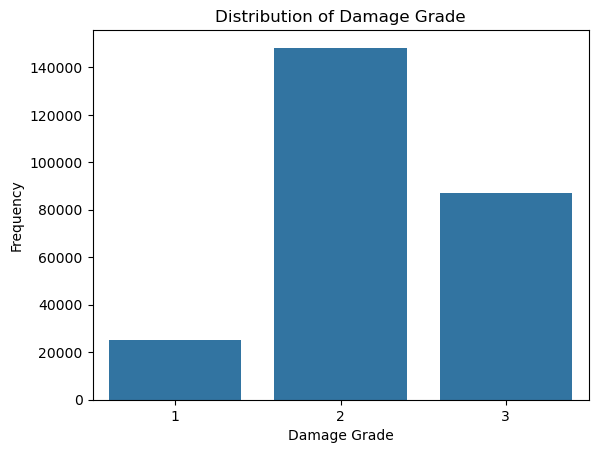

In [9]:
# another class distribution plot of the damage grade
sns.countplot(data=train_values, x='damage_grade')
plt.title('Distribution of Damage Grade')
plt.xlabel('Damage Grade')
plt.ylabel('Frequency');

In [10]:
# foundation type pivot table to see the distribution of damage grade
foundation_type_pivot = pd.pivot_table(
    train_values, index="foundation_type", values="damage_grade", aggfunc=np.mean
    ).sort_values(by="damage_grade")
foundation_type_pivot 

C:\Users\Rodri\AppData\Local\Temp\ipykernel_14260\180311825.py:2: FutureWarning: The provided callable <function mean at 0x000002AECE0DF9C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  foundation_type_pivot = pd.pivot_table(


,damage_grade
foundation_type,
i,1.453351
w,1.810954
u,1.883661
h,2.105663
r,2.329573


In [11]:
# Cardinaility features geo_level
print(f"Unique geo_level_1_id: {train_values['geo_level_1_id'].nunique()}")
print(f"Unique geo_level_2_id: {train_values['geo_level_2_id'].nunique()}")
print(f"Unique geo_level_3_id: {train_values['geo_level_3_id'].nunique()}")

Unique geo_level_1_id: 31
Unique geo_level_2_id: 1414
Unique geo_level_3_id: 11595


In [ ]:
# Impute high cordiniality geo_level data
train_mean = train_values["damage_grade"].mean()

# For geo_1
geo1_mean = train_values.groupby("geo_level_1_id")["damage_grade"].mean().to_dict()
train_values["geo_level_1_id"] = train_values["geo_level_1_id"].map(geo1_mean).fillna(train_mean)
test_values["geo_level_1_id"] = test_values["geo_level_1_id"].map(geo1_mean).fillna(train_mean)

# For geo_2
geo2_mean = train_values.groupby("geo_level_2_id")["damage_grade"].mean().to_dict()
train_values["geo_level_2_id"] = train_values["geo_level_2_id"].map(geo2_mean).fillna(train_mean)
test_values["geo_level_2_id"] = test_values["geo_level_2_id"].map(geo2_mean).fillna(train_mean)

# For geo_3
geo3_mean = train_values.groupby("geo_level_3_id")["damage_grade"].mean().to_dict()
train_values["geo_level_3_id"] = train_values["geo_level_3_id"].map(geo3_mean).fillna(train_mean)
test_values["geo_level_3_id"] = test_values["geo_level_3_id"].map(geo3_mean).fillna(train_mean)

In [50]:
# Turn to integer
train_values["geo_level_1_id"] = train_values["geo_level_1_id"].round().astype(int)
train_values["geo_level_2_id"] = train_values["geo_level_2_id"].round().astype(int)
train_values["geo_level_3_id"] = train_values["geo_level_3_id"].round().astype(int)

# Test values
test_values["geo_level_1_id"] = test_values["geo_level_1_id"].round().astype(int)
test_values["geo_level_2_id"] = test_values["geo_level_2_id"].round().astype(int)
test_values["geo_level_3_id"] = test_values["geo_level_3_id"].round().astype(int)


In [51]:
# test geo level cordiniality
print(f"Unique geo_level_1_id: {train_values['geo_level_1_id'].nunique()}")
print(f"Unique geo_level_2_id: {train_values['geo_level_2_id'].nunique()}")
print(f"Unique geo_level_3_id: {train_values['geo_level_3_id'].nunique()}")
print(train_values["geo_level_3_id"].head())

Unique geo_level_1_id: 2
Unique geo_level_2_id: 3
Unique geo_level_3_id: 3
0    3
1    2
2    3
3    2
4    2
Name: geo_level_3_id, dtype: int64


In [65]:
# check for correlation between grade damage and geo level 3 id
correlation_level3 = train_values["geo_level_3_id"].corr(train_values["damage_grade"])

print(f"Correlation between geo3 and grade damage is: {correlation_level3:0.3}")

Correlation between geo3 and grade damage is: 0.552


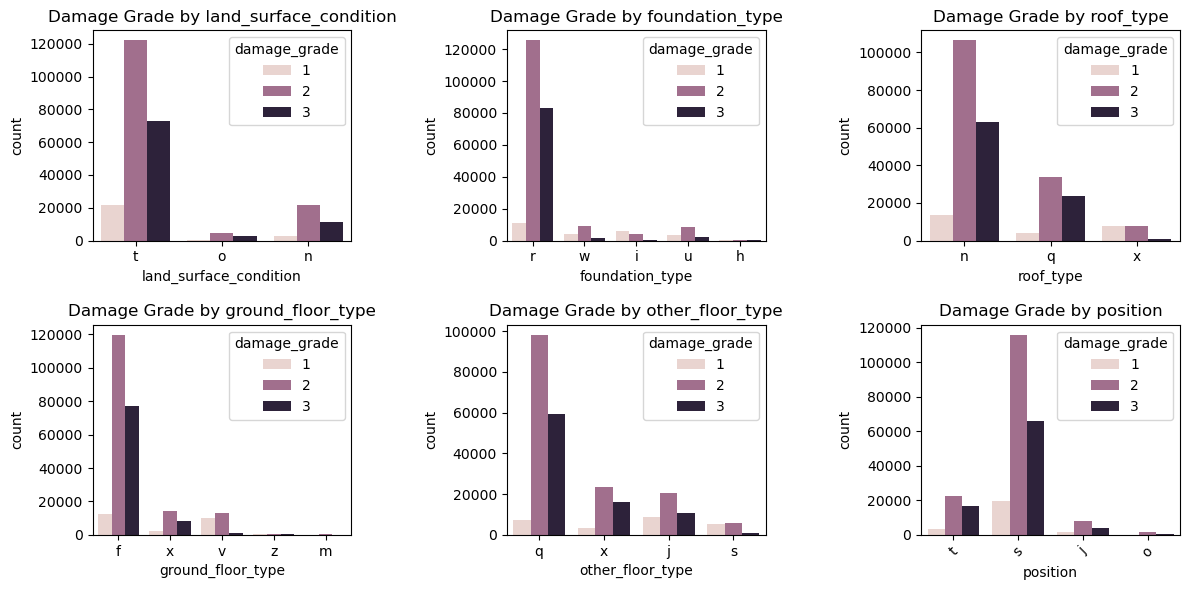

In [20]:
#  Cordiniality categorical features
cols = ["land_surface_condition", "foundation_type", "roof_type", "ground_floor_type", "other_floor_type", "position"]
n_rows = 2
n_cols = (len(cols) + 1) // n_rows

# crite fig size and axes

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.countplot(data=train_values, x=col, hue='damage_grade', ax=axes[i])
    axes[i].set_title(f"Damage Grade by {col}")
    plt.xticks(rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.6)
plt.show();

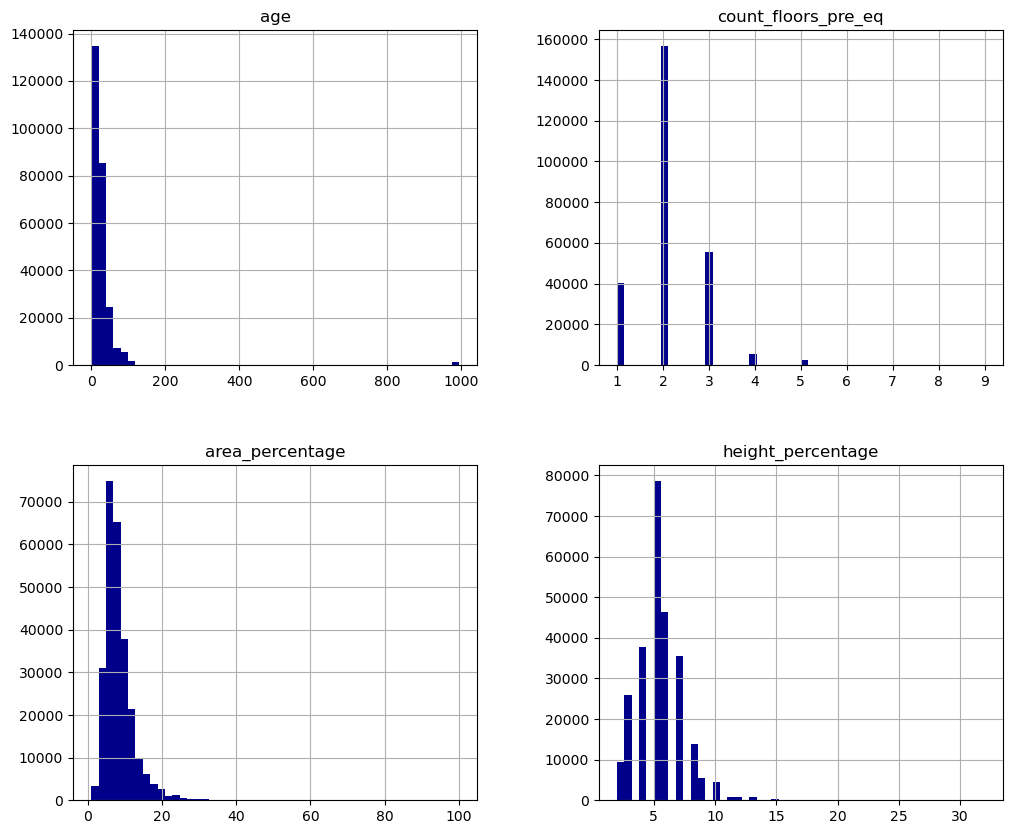

In [21]:
## Distribution & outlier
num_cols = ["age", "count_floors_pre_eq", "area_percentage", "height_percentage"]
train_values[num_cols].hist(bins=50, figsize=(12, 10), color='darkblue');

In [70]:
# Put age gap
age_gap = train_values["age"].quantile(0.99)
train_values["age"] = train_values["age"].clip(upper=age_gap)

In [72]:
# on test data too
test_values["age"] = test_values["age"].clip(upper=age_gap)

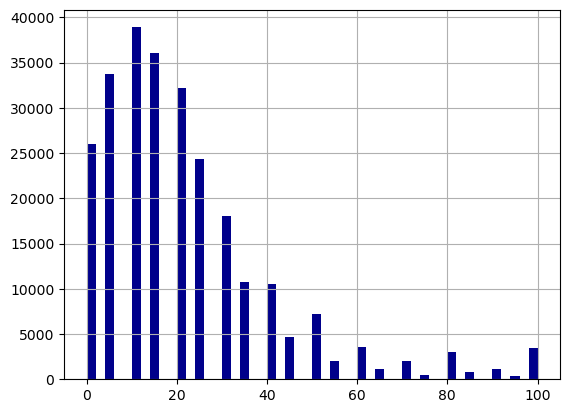

In [71]:
# check the range of the new age
train_values["age"].hist(bins=50, color="darkblue");

In [73]:
print(f"Shape train: {train_values.shape}")
print(f"Shape test: {test_values.shape}")

Shape train: (260601, 40)
Shape test: (86868, 39)


In [74]:
train_values[num_cols].describe()

,age,count_floors_pre_eq,area_percentage,height_percentage
count,260601.000000,260601.000000,260601.000000,260601.000000
mean,21.656229,2.129723,8.018051,5.434365
std,19.800349,0.727665,4.392231,1.918418
min,0.000000,1.000000,1.000000,2.000000
25%,10.000000,2.000000,5.000000,4.000000
50%,15.000000,2.000000,7.000000,5.000000
75%,30.000000,2.000000,9.000000,6.000000
max,100.000000,9.000000,100.000000,32.000000


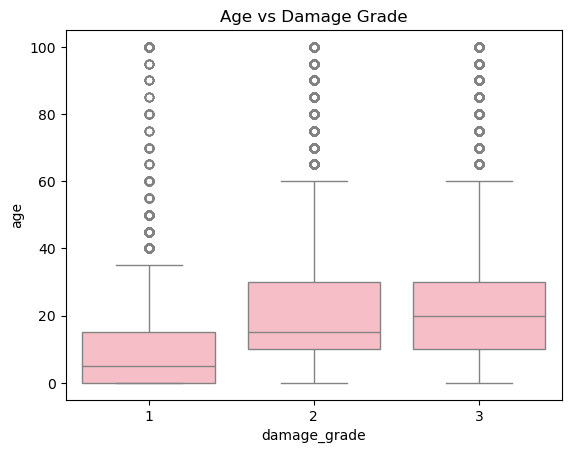

In [75]:
# Correlation with target
sns.boxplot(data=train_values, x='damage_grade', y='age', color='lightpink')
plt.title('Age vs Damage Grade');

<Axes: xlabel='damage_grade', ylabel='area_percentage'>

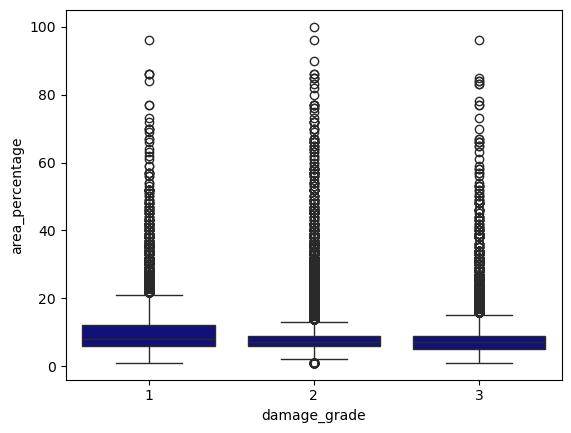

In [31]:
# Count area percentage damage grade
sns.boxplot(data=train_values, x='damage_grade', y='area_percentage', color='darkblue')

In [32]:
# Supperstricture flags
superstructure_cols =[c for c in train_values.columns if "has_superstructure_" in c]
for col in superstructure_cols:
    print(f"\n Damage Grade where {col} is 1:")
    print(train_values[train_values[col]==1]['damage_grade'].value_counts(normalize=True))


 Damage Grade where has_superstructure_adobe_mud is 1:
damage_grade
2    0.601792
3    0.372495
1    0.025713
Name: proportion, dtype: float64

 Damage Grade where has_superstructure_mud_mortar_stone is 1:
damage_grade
2    0.573864
3    0.382019
1    0.044117
Name: proportion, dtype: float64

 Damage Grade where has_superstructure_stone_flag is 1:
damage_grade
2    0.506762
3    0.472896
1    0.020342
Name: proportion, dtype: float64

 Damage Grade where has_superstructure_cement_mortar_stone is 1:
damage_grade
2    0.683502
1    0.174453
3    0.142045
Name: proportion, dtype: float64

 Damage Grade where has_superstructure_mud_mortar_brick is 1:
damage_grade
2    0.658634
3    0.306289
1    0.035077
Name: proportion, dtype: float64

 Damage Grade where has_superstructure_cement_mortar_brick is 1:
damage_grade
2    0.582258
1    0.362223
3    0.055519
Name: proportion, dtype: float64

 Damage Grade where has_superstructure_timber is 1:
damage_grade
2    0.604771
3    0.280226
1    0.

In [36]:
# Feature interactions (Geo level + Material combo)
pd.crosstab(
    index=train_values['geo_level_1_id'], 
    columns=train_values['has_superstructure_rc_engineered'], 
    values=train_values['damage_grade'],
    aggfunc='mean'
    ).style.background_gradient(cmap='Reds')

has_superstructure_rc_engineered,0,1
geo_level_1_id,,
0,2.065918,1.666667
1,1.962839,1.400000
2,2.176149,1.411765
3,2.344432,1.549180
4,2.164211,1.477273
5,1.920925,1.555556
6,2.196745,1.189858
7,2.307532,1.514894
8,2.499283,1.450980


In [98]:
#  convert categorical columns to 'category' dtype
categorical_cols = [
    "land_surface_condition", "foundation_type", "roof_type",
    "ground_floor_type", "other_floor_type", "position", "legal_ownership_status",
    "plan_configuration"
]

for col in categorical_cols:
    train_values[col] = train_values[col].astype("category")

In [138]:
for col in categorical_cols:
    test_values[col] = test_values[col].astype("category")

In [107]:
# Convert the grade damage leve to an understandable value
train_values["damage_grade"] = train_values["damage_grade"].map({1: 0, 2: 1, 3: 2})

### Split data

In [108]:
# gather feature and target data
X_train, X_val, y_train, y_val = train_test_split(
    train_values.drop(columns=["building_id", "damage_grade"]),
    train_values["damage_grade"],
    test_size=0.2,
    random_state=42
)

In [109]:
print(y_train.unique())

[1 2 0]


In [110]:
#  test if the split was well done
print("\n----------")
print(X_train.shape)
print(X_val.shape)
X_train.shape[0] + X_val.shape[0] == train_values.shape[0]


----------
(208480, 38)
(52121, 38)


True

## Model

### Baseline
Stratified random

In [111]:
# Baseline
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_val)
f1_micro = f1_score(y_val, y_pred, average="micro")
print(f"Majority Class Baseline Mico: {f1_micro:.4f}")

Majority Class Baseline Mico: 0.5657


### Build Model

In [112]:
# define params
params = {
    "objective": "multiclass",
    "num_class": 3,
    "metric": "multi_logloss",
    "booting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "n_jobs": -1,
    "verbose": -1
}

# Train
model = lgb.train(
    params,
    lgb.Dataset(X_train, label=y_train),
    num_boost_round=100
)

In [114]:
# Make prediction on X_val data
y_pred = model.predict(X_val).argmax(axis=1) + 1 # convert to 1/2/3

f1_micro = f1_score(y_val + 1, y_pred, average="micro") # Ensure the y_val is also 1,2,3
print(f"LightGBM F1 Micro: {f1_micro:.4f}")

LightGBM F1 Micro: 0.7388


### Tune with Optuna

In [117]:
def objective(trial):
    # Hyperparameters to tune
    params = {
        'objective': 'multiclass',
        'num_class': 3,
        'metric': 'multi_logloss',  # LightGBM's internal metric (not directly F1)
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
    }

    model = lgb.LGBMClassifier(**params)

    # Evaluate using cross validation + F1 score
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5, # 5-fold CV
        scoring="f1_micro", # Use micro_average F1
        n_jobs=-1
    )

    # Return mean F1 score accross fold
    return scores.mean()

In [119]:
# run optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# Best Hyperperameters
print("Best F1 Micro: ", study.best_value)
print("Best params: ", study.best_params)

[I 2025-03-26 21:13:18,369] A new study created in memory with name: no-name-b24bf873-8da2-4231-84b2-2edf56352b0a
[I 2025-03-26 21:13:37,885] Trial 0 finished with value: 0.7366797774366846 and parameters: {'learning_rate': 0.027595982300157237, 'num_leaves': 41, 'max_depth': 3, 'min_child_samples': 48, 'subsample': 0.9317417635086909, 'colsample_bytree': 0.6126252561915962, 'reg_alpha': 0.7385016136212547, 'reg_lambda': 0.08810432940254953}. Best is trial 0 with value: 0.7366797774366846.
[I 2025-03-26 21:13:52,833] Trial 1 finished with value: 0.7402244819646968 and parameters: {'learning_rate': 0.06163848367631515, 'num_leaves': 79, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.6548900811776482, 'colsample_bytree': 0.9935358578149657, 'reg_alpha': 0.9267948491686745, 'reg_lambda': 0.33597982996735376}. Best is trial 1 with value: 0.7402244819646968.
[I 2025-03-26 21:14:15,115] Trial 2 finished with value: 0.7426755564082886 and parameters: {'learning_rate': 0.1159002709712

Best F1 Micro:  0.7426755564082886
Best params:  {'learning_rate': 0.1159002709712165, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 33, 'subsample': 0.9117272767202609, 'colsample_bytree': 0.8572056940433789, 'reg_alpha': 0.615623676725329, 'reg_lambda': 0.5879625337208912}


In [122]:
# Train the best model with full validation data
best_model = lgb.LGBMClassifier(**study.best_params)
best_model.fit(X_train, y_train)

# Prediction on validation set
y_pred = best_model.predict(X_val) + 1 # convert it to 1,2,3
f1_micro = f1_score(y_val + 1, y_pred, average="micro")
print(f"Best LightGBM F1 Micro: {f1_micro:.4f}")

Best LightGBM F1 Micro: 0.7403


In [124]:
y_pred[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 3, 3])

## Communicate Results

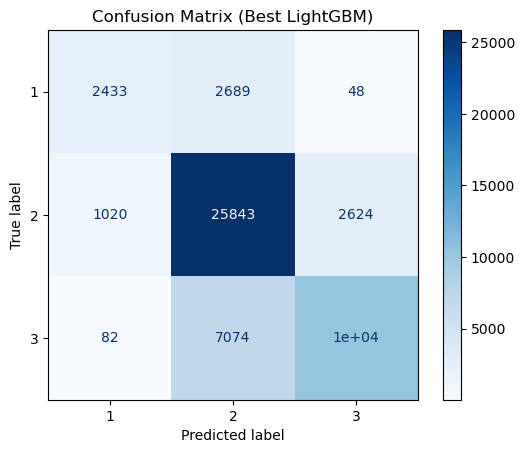

In [126]:
# visualize with confusion matrix
cm  = confusion_matrix(y_val + 1, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[1, 2, 3])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Best LightGBM)");

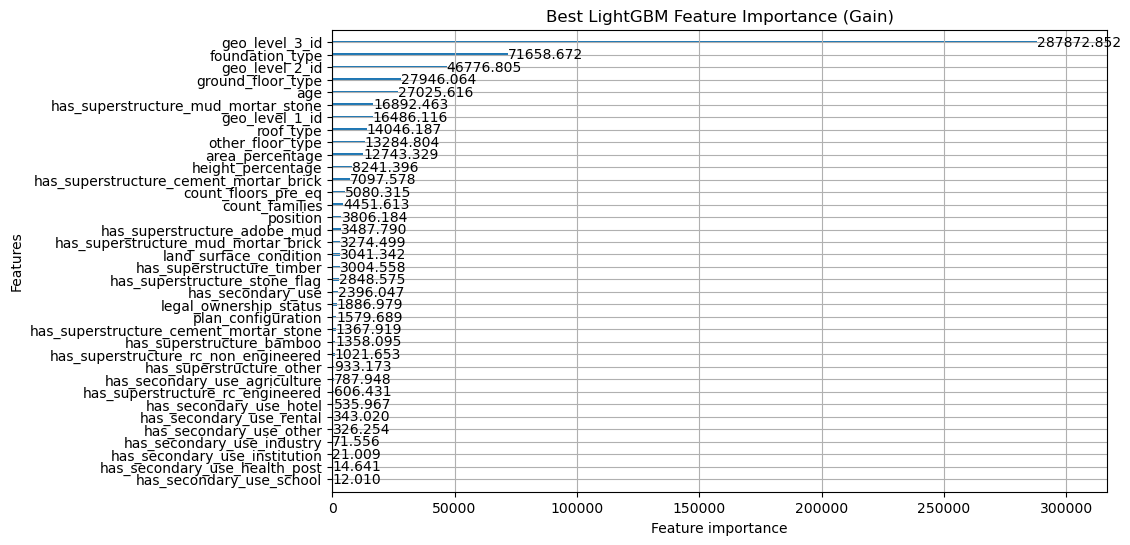

In [127]:
# Feature Importance
lgb.plot_importance(best_model, importance_type="gain", figsize=(10, 6))
plt.title("Best LightGBM Feature Importance (Gain)");

### Summary Statement
Our __tuned LightGBM model__ achieves an _F1 Micro_ of `0.7403`, a `30.9%` improvement over the _majority-class baseline_ `(0.5657)`. Key drivers include `geographic region (geo_level_id)`, `foundation type`, `ground floor type`, `building age`, and `roof type`. Future work could explore ensembles or addressing class imbalance.

### Error Analysis

In [129]:
# classification report
y_true = (y_val + 1).reset_index(drop=True) # Ensure alignment

# Classification report (precision/recall per class)
print(classification_report(y_true, y_pred, target_names=["1", "2", "3"]))

              precision    recall  f1-score   support

           1       0.69      0.47      0.56      5170
           2       0.73      0.88      0.79     29487
           3       0.79      0.59      0.68     17464

    accuracy                           0.74     52121
   macro avg       0.74      0.65      0.68     52121
weighted avg       0.74      0.74      0.73     52121



In [130]:
# Create a DataFrame of errors
val_df = X_val.copy()
val_df['true_grade'] = y_true
val_df['pred_grade'] = y_pred
val_df['is_wrong'] = (y_true != y_pred)

# Filter severe errors (e.g., true=3 predicted as 1)
severe_errors = val_df[(val_df['true_grade'] == 3) & (val_df['pred_grade'] == 1)]
print(f"Severe errors (true=3 → pred=1): {len(severe_errors)}")

Severe errors (true=3 → pred=1): 235


In [132]:
# Compare feature distributions between errors and correct predictions
error_analysis = val_df.groupby('is_wrong').agg({
    'age': 'mean',
    'area_percentage': 'mean',
    'geo_level_3_id': 'mean'
})
print(error_analysis)

                age  area_percentage  geo_level_3_id
is_wrong                                            
False     21.595954         8.014186        2.208722
True      21.501282         8.163676        2.192603


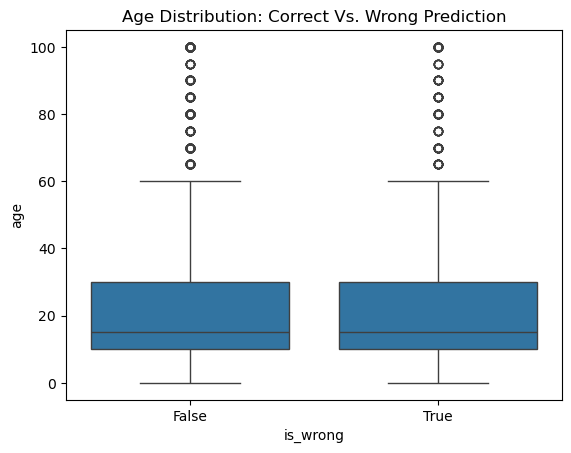

In [133]:
# Plot distribution of correct vs wrong
sns.boxplot(data=val_df, x="is_wrong", y="age")
plt.title("Age Distribution: Correct Vs. Wrong Prediction");

### Submission

In [135]:
# Save model with pickle
with open("lightgbm_damage_prediction.pkl", "wb") as f:
    pickle.dump(best_model, f)

__Predict on full test data__

In [139]:
test = test_values.drop(columns="building_id")

assert len(test) == 86868

In [145]:
# Predict with test
y_pred_test = best_model.predict(test) + 1
print(f"Predictions shape: {y_pred_test.shape}") #must be '86868' (Rodriguez)

Predictions shape: (86868,)


In [146]:
# Save the prediction to csv
df = pd.DataFrame({
    "building_id": test_values["building_id"],
    "damage_grade": y_pred_test.astype(int)
})

df.to_csv("submission.csv", index=False)

In [147]:
df.head()

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,3
3,745817,2
4,421793,3


In [149]:
print(f"Unique damag class: {df['damage_grade'].unique()}")
print(df.info())

Unique damag class: [3 2 1]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   building_id   86868 non-null  int64
 1   damage_grade  86868 non-null  int64
dtypes: int64(2)
memory usage: 1.3 MB
None
